In [ ]:
import torch
from torch.optim import Optimizer
import matplotlib.pyplot as plt
import numpy as np
import time

class GeneralMirrorOptimizer(Optimizer):
    def __init__(self, params, lr, mirror_map, mode="mirror"):
        if lr < 0.0:
            raise ValueError(f"Invalid learning rate: {lr}")
        if mode not in ["mirror", "dual"]:
            raise ValueError(f"Invalid mode: {mode}, choose 'mirror' or 'dual'")
        defaults = dict(lr=lr, mirror_map=mirror_map, mode=mode)
        super(GeneralMirrorOptimizer, self).__init__(params, defaults)

        # For Dual Averaging, keep track of gradient sum and iteration count
        if mode == "dual":
            self.state['grad_sum'] = [torch.zeros_like(p.data) for group in self.param_groups for p in group['params']]
            self.state['t'] = 0

    def step(self, closure=None):
        loss = None
        if closure is not None:
            with torch.enable_grad():
                loss = closure()

        mode = self.param_groups[0]['mode']
        base_lr = self.param_groups[0]['lr']
        mirror_map = self.param_groups[0]['mirror_map']

        if mode == "dual":
            self.state['t'] += 1
            t = self.state['t']
            lr = base_lr / np.sqrt(t)  # decaying learning rate

            idx = 0
            for group in self.param_groups:
                for p in group['params']:
                    if p.grad is not None:
                        grad = p.grad.data
                        self.state['grad_sum'][idx] += grad
                        avg_grad = self.state['grad_sum'][idx] / t
                        p.data = -lr * avg_grad
                        idx += 1


        elif mode == "mirror":
            lr = base_lr  
            for group in self.param_groups:
                for p in group['params']:
                    if p.grad is not None:
                        grad = p.grad.data
                        p.data = mirror_map(p.data - lr * grad)
        return loss


# Mirror map (Euclidean)
def mirror_map(x):
    return x

# Himmelblau's function
def himmelblau(x):
    x1, x2 = x[0], x[1]
    return (x1**2 + x2 - 11)**2 + (x1 + x2**2 - 7)**2

# Gradient of Himmelblau
def grad_himmelblau(x):
    x1, x2 = x[0], x[1]
    df_dx = 4*x1*(x1**2 + x2 - 11) + 2*(x1 + x2**2 - 7)
    df_dy = 2*(x1**2 + x2 - 11) + 4*x2*(x1 + x2**2 - 7)
    return torch.tensor([df_dx, df_dy], dtype=torch.float32)

# Initial point
x = torch.nn.Parameter(torch.rand(2, dtype=torch.float32) * 6 - 3)  # range [-3, 3]

# Euclidean Mirror Descent
optimizer = GeneralMirrorOptimizer([x], lr=1e-3, mirror_map=mirror_map, mode="mirror")

trajectory = [x.detach().clone()]
losses = []
tolerance = 1e-3

start_time = time.time()

for i in range(50000):
    optimizer.zero_grad()
    loss = himmelblau(x)
    loss.backward()
    optimizer.step()

    trajectory.append(x.detach().clone())
    losses.append(loss.item())

    grad_norm = torch.norm(x.grad.detach())
    if grad_norm < tolerance:
        print(f"Early stopping at step {i}, final point: {x.detach()}, grad norm: {grad_norm:.6f}")
        break

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time:.2f} seconds")

# Threshold check
thresholds = [10.0, 1.0, 0.1, 0.01]
for t in thresholds:
    steps = next((i for i, l in enumerate(losses) if l < t), None)
    if steps is not None:
        print(f"Loss < {t} reached at iteration {steps}")
    else:
        print(f"Loss < {t} not reached")

# Trajectory visualization
trajectory = torch.stack(trajectory).numpy()

X, Y = np.meshgrid(np.linspace(-5, 5, 400), np.linspace(-5, 5, 400))
Z = (X**2 + Y - 11)**2 + (X + Y**2 - 7)**2

plt.figure(figsize=(12, 7))
plt.contourf(X, Y, Z, levels=50, cmap="cividis")
plt.plot(trajectory[:, 0], trajectory[:, 1], color="red", label="SMD trajectory")
plt.scatter([3.0], [2.0], color='green', s=200, label='Minima example (3,2)')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.title("Mirror Descent optimizing Himmelblau's function")
plt.grid(True)
plt.show()

# Loss curve
plt.figure(figsize=(10, 4))
plt.plot(losses)
plt.yscale("log")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Loss over Iterations (log scale)")
plt.grid(True)
plt.show()


UnboundLocalError: cannot access local variable 'lr' where it is not associated with a value

Elapsed time: 6.47 seconds
Loss < 10.0 not reached
Loss < 1.0 not reached
Loss < 0.1 not reached
Loss < 0.01 not reached


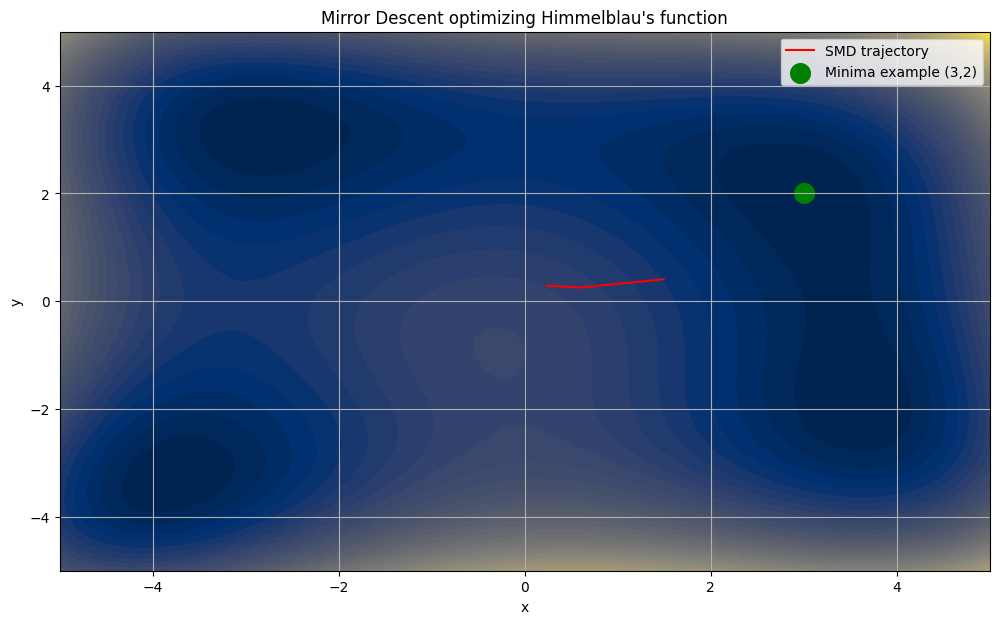

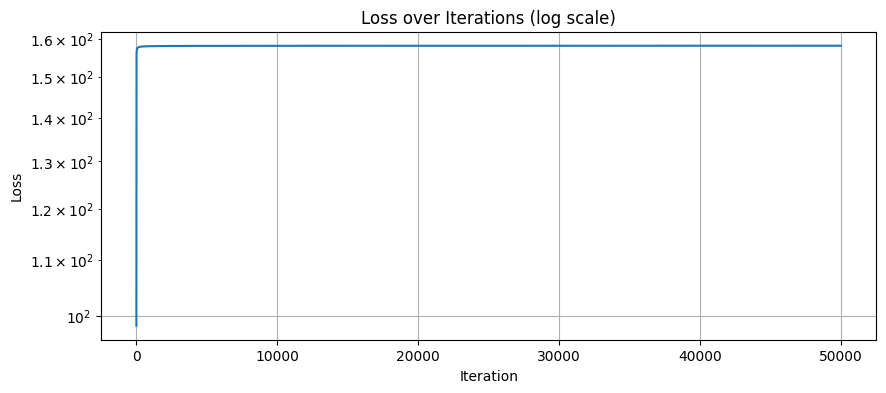

In [3]:
# Initial point
x = torch.nn.Parameter(torch.rand(2, dtype=torch.float32) * 6 - 3)  # range [-3, 3]

# Dual Averaging Mirror Descent
optimizer = GeneralMirrorOptimizer([x], lr=1e-2, mirror_map=mirror_map, mode="dual")

trajectory = [x.detach().clone()]
losses = []
tolerance = 1e-3

start_time = time.time()

for i in range(50000):
    optimizer.zero_grad()
    loss = himmelblau(x)
    loss.backward()
    optimizer.step()

    trajectory.append(x.detach().clone())
    losses.append(loss.item())

    grad_norm = torch.norm(x.grad.detach())
    if grad_norm < tolerance:
        print(f"Early stopping at step {i}, final point: {x.detach()}, grad norm: {grad_norm:.6f}")
        break

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time:.2f} seconds")

# Threshold check
thresholds = [10.0, 1.0, 0.1, 0.01]
for t in thresholds:
    steps = next((i for i, l in enumerate(losses) if l < t), None)
    if steps is not None:
        print(f"Loss < {t} reached at iteration {steps}")
    else:
        print(f"Loss < {t} not reached")

# Trajectory visualization
trajectory = torch.stack(trajectory).numpy()

X, Y = np.meshgrid(np.linspace(-5, 5, 400), np.linspace(-5, 5, 400))
Z = (X**2 + Y - 11)**2 + (X + Y**2 - 7)**2

plt.figure(figsize=(12, 7))
plt.contourf(X, Y, Z, levels=50, cmap="cividis")
plt.plot(trajectory[:, 0], trajectory[:, 1], color="red", label="SMD trajectory")
plt.scatter([3.0], [2.0], color='green', s=200, label='Minima example (3,2)')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.title("Mirror Descent optimizing Himmelblau's function")
plt.grid(True)
plt.show()

# Loss curve
plt.figure(figsize=(10, 4))
plt.plot(losses)
plt.yscale("log")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Loss over Iterations (log scale)")
plt.grid(True)
plt.show()
